In [246]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# (1) https://www.sciencedirect.com/science/article/pii/S0968432822000245 
# (2) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [248]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

#usar fonts do latex
plt.rcParams.update(tex_fonts)

## Hertz and JKR functions

In [249]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

# Johnson-Kendall-Roberts model for indentation
# (3) https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    # JKR force formula in (3)
    force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

## Parameter definition

In [250]:
# resolution of the map
res = 20
# random values
size = res * res
# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
E = np.random.normal(loc=1.0, scale=0.3, size=size)
# Poisson's ratio 
nu = 0.5
# surface energy
    #gamma in (3) is given in J sub-units(???), but gamma <> Ua
gamma = 0.1
# radius of the indenter
r = 1.0

(array([ 4., 12., 12., 16., 27., 22., 45., 45., 45., 49., 39., 37., 19.,
        10.,  7.,  3.,  3.,  3.,  1.,  1.]),
 array([0.25221799, 0.34141968, 0.43062136, 0.51982305, 0.60902474,
        0.69822643, 0.78742812, 0.8766298 , 0.96583149, 1.05503318,
        1.14423487, 1.23343656, 1.32263824, 1.41183993, 1.50104162,
        1.59024331, 1.67944499, 1.76864668, 1.85784837, 1.94705006,
        2.03625175]),
 <BarContainer object of 20 artists>)

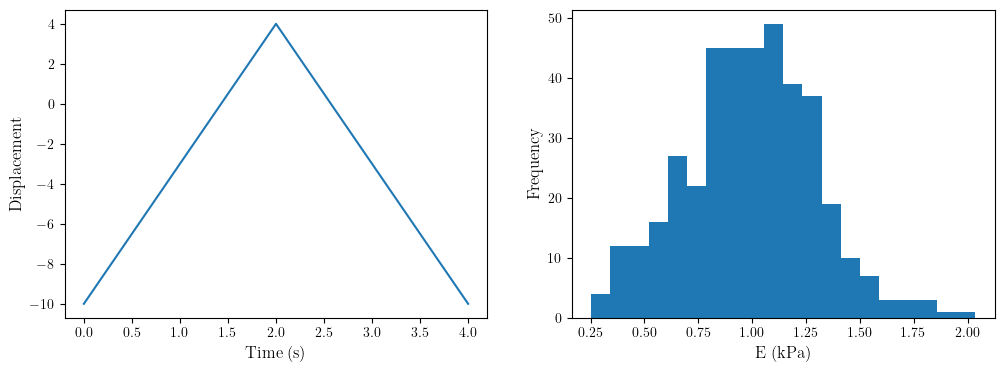

In [251]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-10, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 4, 20

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement')
ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')
ax2.hist(E, 20)

## Initial df

In [252]:
# construct dataframe
df = pd.DataFrame()
# 'E' array to list:
df['E'] = E.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)


C:\Users\luisr\AppData\Local\Temp\ipykernel_10968\2075678178.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_10968\2075678178.py:54: RuntimeWarning: invalid value encountered in power
  force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75


## Initial df - plots

(4.7, -10.7, -0.9868708377688551, 20.669391785865642)

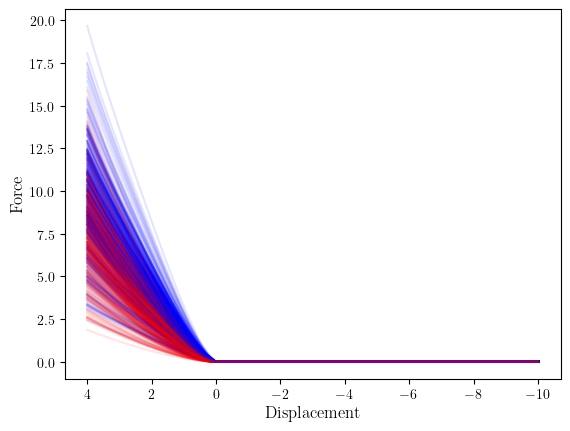

In [253]:
# plot all entries naively
# i: row index; row: data of each row in series format
for i, row in df.iterrows():
    #alpha: transparecy
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
#add labels
plt.xlabel('Displacement')
plt.ylabel('Force')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

C:\Users\luisr\AppData\Local\Temp\ipykernel_10968\3593840353.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
C:\Users\luisr\AppData\Local\Temp\ipykernel_10968\3593840353.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')


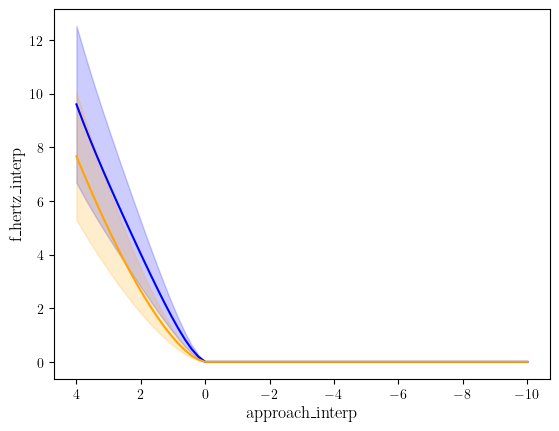

In [254]:
# plot all entries with seaborn
    # set_index: sets 'E' as the index (so the right value o E is assigned to the correct rows after the explode)
    # Series.explode: 'explodes' the arrays (disp and force) into different rows (scalars in each cell instead of arrays)
    # reset_index: because E is no longer needed as an index
df2 = df.set_index(['E']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')
ax.invert_xaxis()

## Initial df - Mapping E

<AxesSubplot: >

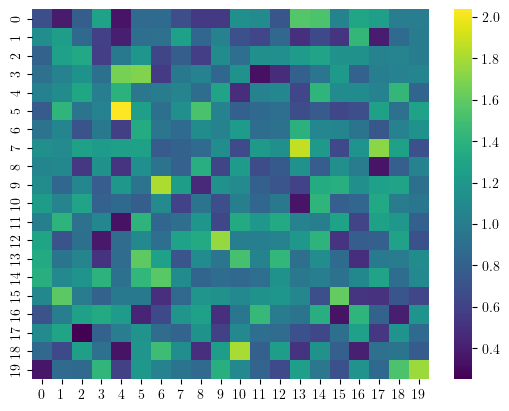

In [255]:
# map random values to a 2D array
#transforms E from array to matrix
E_map = np.reshape(E, (res, res))
# Young's modulus random map
sns.heatmap(E_map, cmap='viridis')
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

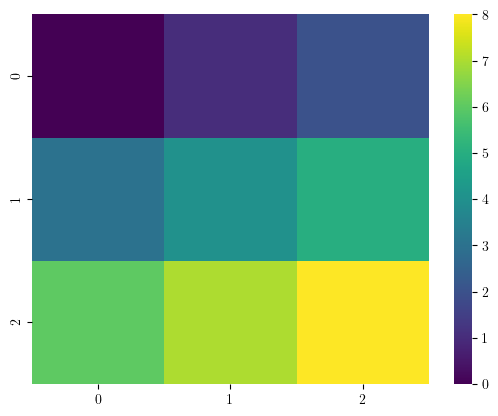

In [256]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.

# **HERTZ**

In [257]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>=0])
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact)-1:])
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape)

(20,) (20,)


### Inputs and labels

In [258]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
# check array dimensions
print(x_hc.shape, y_hc.shape)

(400, 2) (400,)


### Splitting with train_test_split()

array([[array([0.        , 0.32869458, 0.49958775, 0.5741608 , 0.97489601,
               1.39877621, 1.64846019, 1.67770597, 1.84540025, 1.90371321,
               2.03476457, 2.103548  , 2.32583843, 2.53545323, 2.8469693 ,
               3.26365539, 3.44503153, 3.50674339, 3.89881057, 4.        ]),
        array([ 0.        ,  0.40033248,  0.73682366,  0.90064815,  1.90787631,
                3.12750533,  3.89019368,  3.98102958,  4.50675013,  4.69128243,
                5.10875486,  5.32924704,  6.04753161,  6.73237199,  7.76516253,
                9.18821329,  9.83067217, 10.05358925, 11.53841405, 11.94589897])],
       [array([0.        , 0.35675244, 0.39687515, 0.59403705, 0.97160045,
               1.38635877, 1.65857317, 1.69854861, 1.84200469, 1.93317529,
               1.99001029, 2.00201427, 2.16773031, 2.52400255, 2.8079285 ,
               3.08437098, 3.19253859, 3.55456989, 3.69937841, 4.        ]),
        array([0.        , 0.30982029, 0.36200909, 0.6492317 , 1.30346127

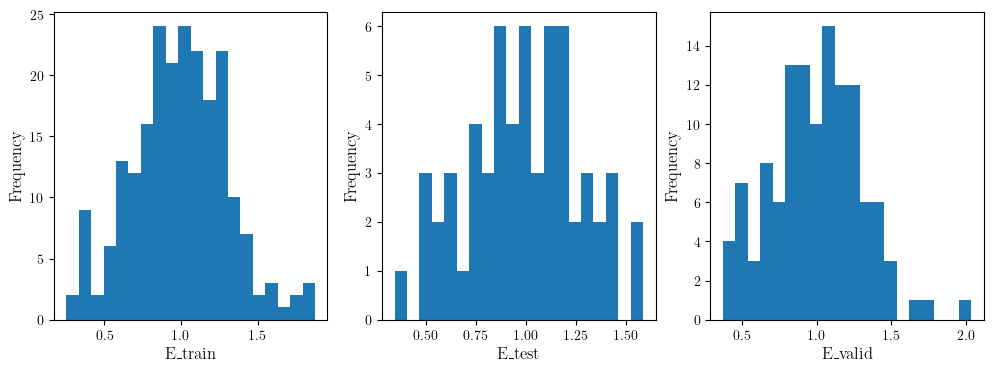

In [259]:
test_ratio = 0.15
# (!!!) validation ratio is currently given in relation to the entire dataset (!!!!)
valid_ratio = 0.3 
rnd_state = None

# Without stratify
#x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state)

#With stratify
bin_count = 20
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio/(1-test_ratio),
                                                       random_state=rnd_state, stratify = bins)


fig, (ax3, ax4, ax5) = plt.subplots(1,3, figsize=(12,4))
plt.ylabel('Frequency')
ax3.set_xlabel('E_train')
ax4.set_xlabel('E_test')
ax5.set_xlabel('E_valid')
for i in (ax3, ax4, ax5):
    i.set_ylabel('Frequency')
ax3.hist(y_train, 20)
ax4.hist(y_test, 20)
ax5.hist(y_valid, 20)

x_train

## ML

### 1st Regression Model

In [260]:
class Regression_Hertz_V1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Using two linear layers
        self.layers = nn.Sequential(nn.Linear(in_features=2, out_features=64),
                                    nn.ReLU(), # try other nonlinear activation functions
                                    nn.Linear(in_features=64, out_features=16),
                                    nn.ReLU(),
                                    nn.Linear(in_features=16, out_features=1))
    
    def forward(self, x):
        return self.layers(x)

# torch.randn(20,2)

model_V1 = Regression_Hertz_V1()
print(model_V1)


Regression_Hertz_V1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [261]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_V1.parameters(),
                            lr = 0.01)

In [269]:
# Training and test data from np arrays to torch tensor with desired shape
def tensor_input_shape(nparray):
    '''
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((nparray[i,0].reshape((n_pts,1)), nparray[i,1].reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

x_train_t = tensor_input_shape(x_train)
x_valid_t = tensor_input_shape(x_valid)
x_test_t = tensor_input_shape(x_test)
y_train_t = torch.from_numpy(y_train).type(torch.float)
y_valid_t = torch.from_numpy(y_valid).type(torch.float)
y_test_t = torch.from_numpy(y_test).type(torch.float)


x_train_t.shape, y_train_t.shape


torch.Size([219, 20, 2])

In [263]:
torch.manual_seed(42)
epochs = 100

for epoch in range(epochs):
    ### Training
    model_V1.train()
    # 1. Forward pass
    y_pred = model_V1(x_train_t)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train_t)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_V1.eval()
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_V1(x_test_t)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_t)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


    

Epoch: 0 | Train loss: 1.5410557985305786 | Test loss: 0.8659616708755493
Epoch: 10 | Train loss: 0.37626853585243225 | Test loss: 0.3447030782699585


c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([219])) that is different to the input size (torch.Size([219, 20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 20 | Train loss: 0.3049970269203186 | Test loss: 0.27723821997642517
Epoch: 30 | Train loss: 0.2491377741098404 | Test loss: 0.22417165338993073
Epoch: 40 | Train loss: 0.2054477483034134 | Test loss: 0.18268603086471558
Epoch: 50 | Train loss: 0.1718544065952301 | Test loss: 0.1508985161781311
Epoch: 60 | Train loss: 0.1465969979763031 | Test loss: 0.12710411846637726
Epoch: 70 | Train loss: 0.12776313722133636 | Test loss: 0.10932227969169617
Epoch: 80 | Train loss: 0.11502473801374435 | Test loss: 0.09767205268144608
Epoch: 90 | Train loss: 0.10735217481851578 | Test loss: 0.09061544388532639


In [264]:
loss_fn(y_pred, y_train_t), y_pred.shape, y_train_t.shape

(tensor(0.1029, grad_fn=<MseLossBackward0>),
 torch.Size([219, 20, 1]),
 torch.Size([219]))

In [265]:
test_pred.shape

torch.Size([60, 20, 1])